In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from tqdm import tqdm
import xgboost as xgb
import cvxpy as cp
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, IntDistribution, CategoricalDistribution

import sys
sys.path.append('../scripts')

import models
import data
import utils

%load_ext autoreload
%autoreload 2

In [2]:
seed = 0

In [14]:
X, Y = data.load_taiwan()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
A_train = X_train.SEX_Female.values.astype(int)
A_test = X_test.SEX_Female.values.astype(int)

## Model without fairness

Performing a search with Optuna, it will perform a 5-fold cross validation and select the parameters with the best mean score. The score used is the ROC.

In [17]:
model_search = OptunaSearchCV(
    models.XGBoostWrapper(),
    {
        "n_estimators" : IntDistribution(5, 50, step=3),
        "colsample_bytree" : FloatDistribution(0.1, 1),
        "max_depth" : IntDistribution(3, 10),
        "l2_weight" : FloatDistribution(0.01, 100),
    },
    n_trials=20,
    random_state = seed,
    verbose = 0,
)
model_search.fit(X_train, Y_train);


/tmp/ipykernel_750/172780997.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model_search = OptunaSearchCV(
[I 2023-11-04 14:26:29,802] A new study created in memory with name: no-name-a329b16f-a067-4c29-b527-57df1c137d6f


[I 2023-11-04 14:26:31,692] Trial 0 finished with value: 0.7732671489360564 and parameters: {'n_estimators': 26, 'colsample_bytree': 0.7171410857599202, 'max_depth': 10, 'l2_weight': 19.56768505212063}. Best is trial 0 with value: 0.7732671489360564.
[I 2023-11-04 14:26:32,403] Trial 1 finished with value: 0.7803713333879637 and parameters: {'n_estimators': 32, 'colsample_bytree': 0.9825239593893744, 'max_depth': 4, 'l2_weight': 70.14984882186943}. Best is trial 1 with value: 0.7803713333879637.
[I 2023-11-04 14:26:34,837] Trial 2 finished with value: 0.7765198297938818 and parameters: {'n_estimators': 44, 'colsample_bytree': 0.8170383657279878, 'max_depth': 9, 'l2_weight': 51.755041166415}. Best is trial 1 with value: 0.7803713333879637.
[I 2023-11-04 14:26:35,260] Trial 3 finished with value: 0.7578528940222823 and parameters: {'n_estimators': 5, 'colsample_bytree': 0.366928223143962, 'max_depth': 4, 'l2_weight': 7.841888105860967}. Best is trial 1 with value: 0.7803713333879637.
[I 

In [18]:
utils.eval_model_train_test(
    model_search,
    X_train, Y_train, A_train,
    X_test, Y_test, A_test,
)

,roc,tpr,fnr,logloss,threshold,accuracy,precision,name
0,0.803744,0.724138,0.275862,0.437782,0.210316,0.732031,0.470149,train_g0
1,0.807737,0.663211,0.336789,0.396285,0.210316,0.770030,0.461807,train_g1
2,0.791795,0.702290,0.297710,0.425279,0.210316,0.713731,0.420571,test_g0
3,0.779272,0.633894,0.366106,0.415870,0.210316,0.757600,0.445455,test_g1


In [21]:
best_params = model_search.best_params_
best_params

{'n_estimators': 47,
 'colsample_bytree': 0.6771831884850028,
 'max_depth': 4,
 'l2_weight': 85.35794872649303}

## Model with dual step

In [22]:
def logloss_grad(predt, dtrain):
    '''Compute the gradient for log loss.'''
    y = dtrain.get_label()
    predt = 1 / (1 + np.exp(-predt))
    grad = -(y - predt)
    return grad

def logloss_hessian(predt, dtrain):
    '''Compute the hessian for log loss.'''
    predt = 1 / (1 + np.exp(-predt))
    hess = (predt * (1 - predt))
    return hess

In [23]:
def logloss_group(predt, dtrain, subgroup):
    y = dtrain.get_label()
    predt = 1 / (1 + np.exp(-predt))
    loss = - (y * np.log(predt) + (1 - y) * np.log(1 - predt))
    groups = np.unique(subgroup)
    loss_matrix = np.zeros((len(y), len(groups)))

    for i, group in enumerate(groups):
        loss_matrix[:, i] = loss # copy the column
        loss_matrix[subgroup!= group, i] = 0 # and set 0 for other groups

    loss_matrix = np.sum(loss_matrix, axis = 0)  / np.sum(loss_matrix != 0, axis = 0)
    return loss_matrix


def logloss_grad_group(predt, dtrain, subgroup):
    '''Compute the gradient for log loss for each group.'''
    y = dtrain.get_label()
    predt = 1 / (1 + np.exp(-predt))
    grad = -(y - predt)

    groups = np.unique(subgroup)
    grad_matrix = np.zeros((len(y), len(groups)))

    for i, group in enumerate(groups):
        grad_matrix[:, i] = grad # copy the column
        grad_matrix[subgroup!= group, i] = 0 # and set 0 for other groups
    return grad_matrix


def logloss_hessian_group(predt, dtrain, subgroup):
    '''Compute the hessian for log loss for each group.'''
    predt = 1 / (1 + np.exp(-predt))
    hess = (predt * (1 - predt))

    groups = np.unique(subgroup)
    hess_matrix = np.zeros((len(hess), len(groups)))

    for i, group in enumerate(groups):
        hess_matrix[:, i] = hess # copy the column
        hess_matrix[subgroup!= group, i] = 0 # and set 0 for other groups
    return hess_matrix

In [24]:
def penalize_max_loss_subgroups(subgroup_idx, fair_weight):
    weight_1 = 1 
    weight_2 = fair_weight 


    def custom_obj(predt, dtrain):

        subgroup = (dtrain.get_data()[:, subgroup_idx]).toarray().reshape(-1)
        
        if weight_2 > 0:
            # dual problem
            loss_group = logloss_group(predt, dtrain, subgroup)
            mu = cp.Variable(loss_group.shape[0]) # number of groups
            z = cp.Variable(1) # z is the min of mu * loss
            constraints = [cp.sum(mu) == weight_2, mu >= 0] + [z <= mu[i] * loss_group[i] for i in range(loss_group.shape[0])]

            objective = cp.Maximize(z)
            problem = cp.Problem(objective, constraints)
            problem.solve()

            # primal problem
            mu_opt = mu.value
        else:
            mu_opt = np.zeros(len(np.unique(subgroup)))
            
        grad_group = logloss_grad_group(predt, dtrain, subgroup)
        hess_group = logloss_hessian_group(predt, dtrain, subgroup)
        grad = logloss_grad(predt, dtrain) * weight_1 + np.sum(mu_opt * grad_group, axis=1) 
        hess = logloss_hessian(predt, dtrain) * weight_1 + np.sum(mu_opt * hess_group, axis=1)

        return grad, hess
    return custom_obj

Train dual problem with hyperparameter selection and fixed fairness weight.

In [26]:
model_search_fair = OptunaSearchCV(
    models.XGBoostWrapper(objective = penalize_max_loss_subgroups(0, 1)),
    {
        "n_estimators" : IntDistribution(5, 50, step=3),
        "colsample_bytree" : FloatDistribution(0.1, 1),
        "max_depth" : IntDistribution(3, 10),
        "l2_weight" : FloatDistribution(0.01, 100),
    },
    n_trials=20,
    random_state = seed,
    verbose = 0,
)
model_search_fair.fit(X_train, Y_train);

/tmp/ipykernel_750/3516891380.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model_search_fair = OptunaSearchCV(
[I 2023-11-04 14:27:36,891] A new study created in memory with name: no-name-499e965a-c297-4483-a30e-1d2321fc6aad


[I 2023-11-04 14:28:00,971] Trial 0 finished with value: 0.7738209000972283 and parameters: {'n_estimators': 26, 'colsample_bytree': 0.7171410857599202, 'max_depth': 10, 'l2_weight': 19.56768505212063}. Best is trial 0 with value: 0.7738209000972283.
[I 2023-11-04 14:28:27,496] Trial 1 finished with value: 0.7797918739274806 and parameters: {'n_estimators': 32, 'colsample_bytree': 0.9825239593893744, 'max_depth': 4, 'l2_weight': 70.14984882186943}. Best is trial 1 with value: 0.7797918739274806.
[I 2023-11-04 14:29:08,869] Trial 2 finished with value: 0.7764294329612719 and parameters: {'n_estimators': 44, 'colsample_bytree': 0.8170383657279878, 'max_depth': 9, 'l2_weight': 51.755041166415}. Best is trial 1 with value: 0.7797918739274806.
[I 2023-11-04 14:29:13,825] Trial 3 finished with value: 0.7578511369041727 and parameters: {'n_estimators': 5, 'colsample_bytree': 0.366928223143962, 'max_depth': 4, 'l2_weight': 7.841888105860967}. Best is trial 1 with value: 0.7797918739274806.
[I 

In [27]:
best_params_fair = model_search_fair.best_params_
best_params_fair

{'n_estimators': 38,
 'colsample_bytree': 0.6841930080310683,
 'max_depth': 8,
 'l2_weight': 99.18111295291132}

In [28]:
utils.eval_model_train_test(
    model_search_fair,
    X_train, Y_train, A_train,
    X_test, Y_test, A_test,
)

,roc,tpr,fnr,logloss,threshold,accuracy,precision,name
0,0.846605,0.799915,0.200085,0.403641,0.195337,0.738404,0.480194,train_g0
1,0.851121,0.749498,0.250502,0.365861,0.195337,0.777377,0.476403,train_g1
2,0.792790,0.732824,0.267176,0.424196,0.195337,0.695164,0.404211,test_g0
3,0.778392,0.652005,0.347995,0.416572,0.195337,0.740771,0.423529,test_g1


In [32]:
lambda_value

1000000.0

In [31]:
lambda_values = np.append([0],np.logspace(-6, 6, num=25))
results = []
for lambda_value in tqdm(lambda_values):
    dual_model_ = models.XGBoostWrapper(
        objective = penalize_max_loss_subgroups(0, lambda_value),
        **best_params_fair
    )
    dual_model_.fit(X_train, Y_train);
    results_df = utils.eval_model_train_test(
        dual_model_,
        X_train, Y_train, A_train,
        X_test, Y_test, A_test,
    )
    results_df["lambda"] = lambda_value
    results.append(results_df)
results = pd.concat(results)

  0%|          | 0/26 [00:00<?, ?it/s]

 92%|█████████▏| 24/26 [03:29<00:17,  8.56s/it]/home/giovani/anaconda3/envs/dual_fair_boost/lib/python3.8/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 96%|█████████▌| 25/26 [03:44<00:08,  8.96s/it]


SolverError: Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.

In [33]:
results = pd.concat(results)

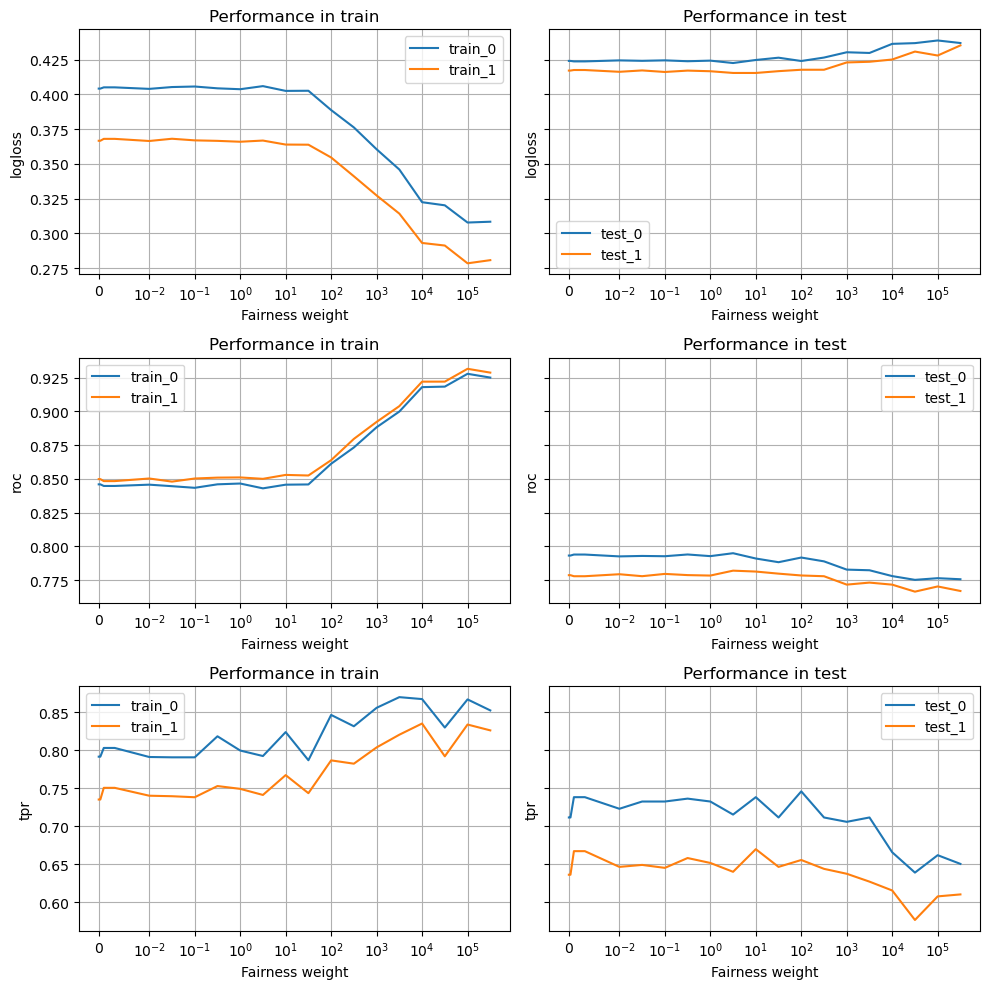

In [34]:
utils.comparison_subgrous_metrics_lambda(results)